In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from matplotlib.colors import ListedColormap
from datetime import datetime 
from pandas import Series, DataFrame 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

%matplotlib inline

RANDOM_STATE = 42

# ВСЯКИЕ ФУНКЦИИ

In [2]:
def memory_analyse(df):
    for dtype in ['float','int','object']:
        selected_dtype = df.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

def show_data(df):
    for col in df.columns:
        print("{0}: {1}".format(col, df[col].unique()))
    print(df.columns)
    

def make_submission(ids, preds, output_path='submission.csv'):
    subm = pd.DataFrame()
    subm['id'] = ids
    subm['income'] = preds
    subm.to_csv(output_path, index=False) 

def corr(df):
    s1 = pd.Series(df["income"])
    for col in df.columns:
        if (col != "date"):
            s2 = pd.Series(df[col])
            c = s1.corr(s2 )
            print("corr {0} with price: {1}".format(col, c))
            
def make_NaN(df):
    for col in df.columns:
        df[col][df[col] == ' ?'] = None
            
def find_NaN(df):
    nans = df.loc[:, df.isnull().any()].copy()
    print(nans.columns)
    nans = nans.isna().sum()
    print(nans)

# АНАЛИЗ

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
train.shape

(32561, 15)

In [6]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [7]:
train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [8]:
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [9]:
train.describe(include=['object'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [11]:
memory_analyse(train)

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 0.21 MB
Average memory usage for object columns: 1.87 MB


In [12]:
#минимизация затрат по памяти
for col in train.columns:
    if (train[col].dtype == int):
        test[col] = test[col].astype('int32')
        train[col] = train[col].astype('int32')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int32
workclass         32561 non-null object
fnlwgt            32561 non-null int32
education         32561 non-null object
education-num     32561 non-null int32
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int32
capital-loss      32561 non-null int32
hours-per-week    32561 non-null int32
native-country    32561 non-null object
income            32561 non-null object
dtypes: int32(6), object(9)
memory usage: 3.0+ MB


In [13]:
memory_analyse(train)

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 1.87 MB


In [14]:
train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

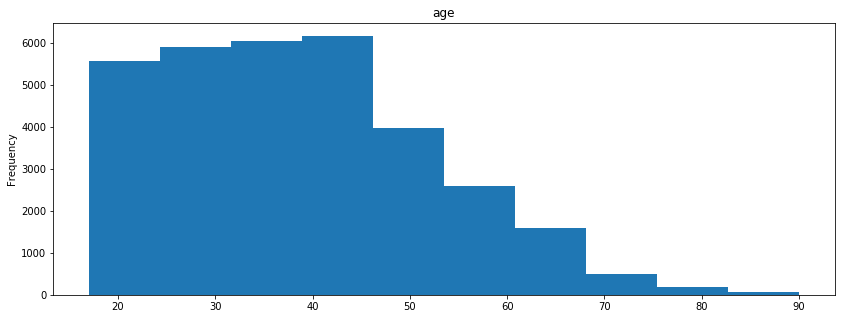

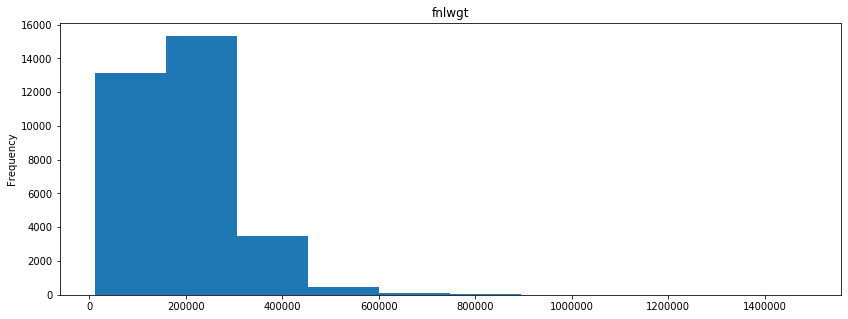

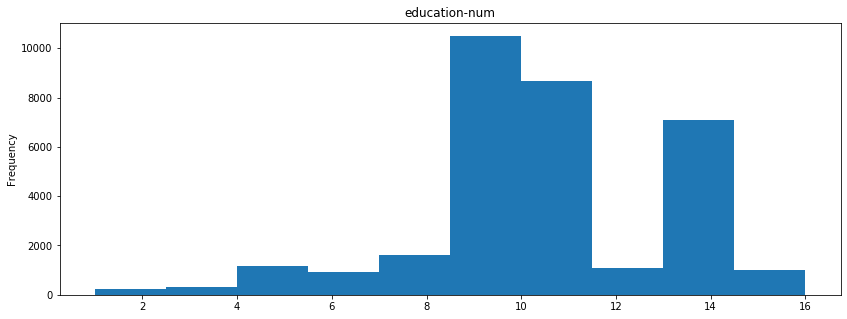

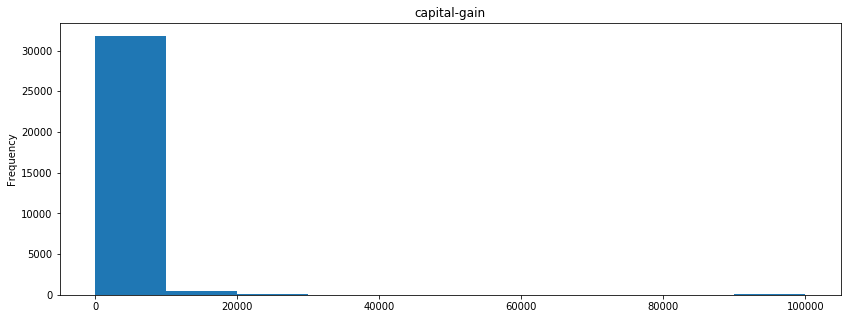

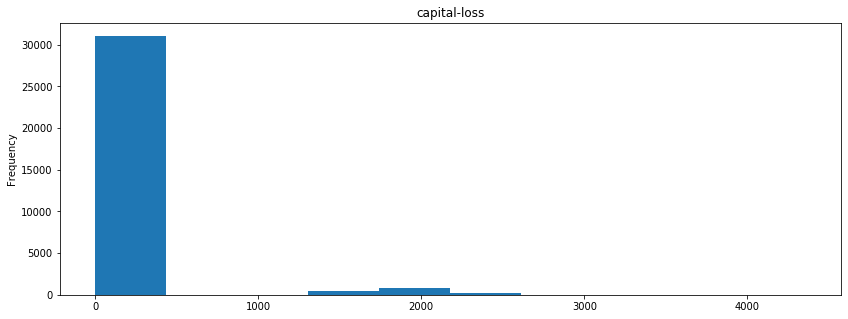

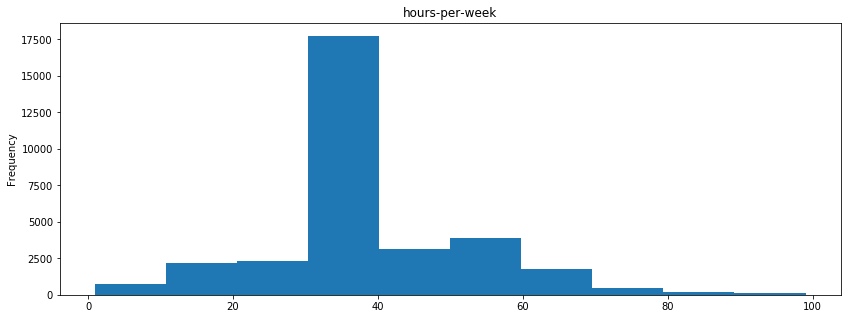

In [15]:
cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

for col in cols:
    fig = plt.figure(figsize=(14,5))
    plt.title(col)
    train[col].plot.hist(bins=10)

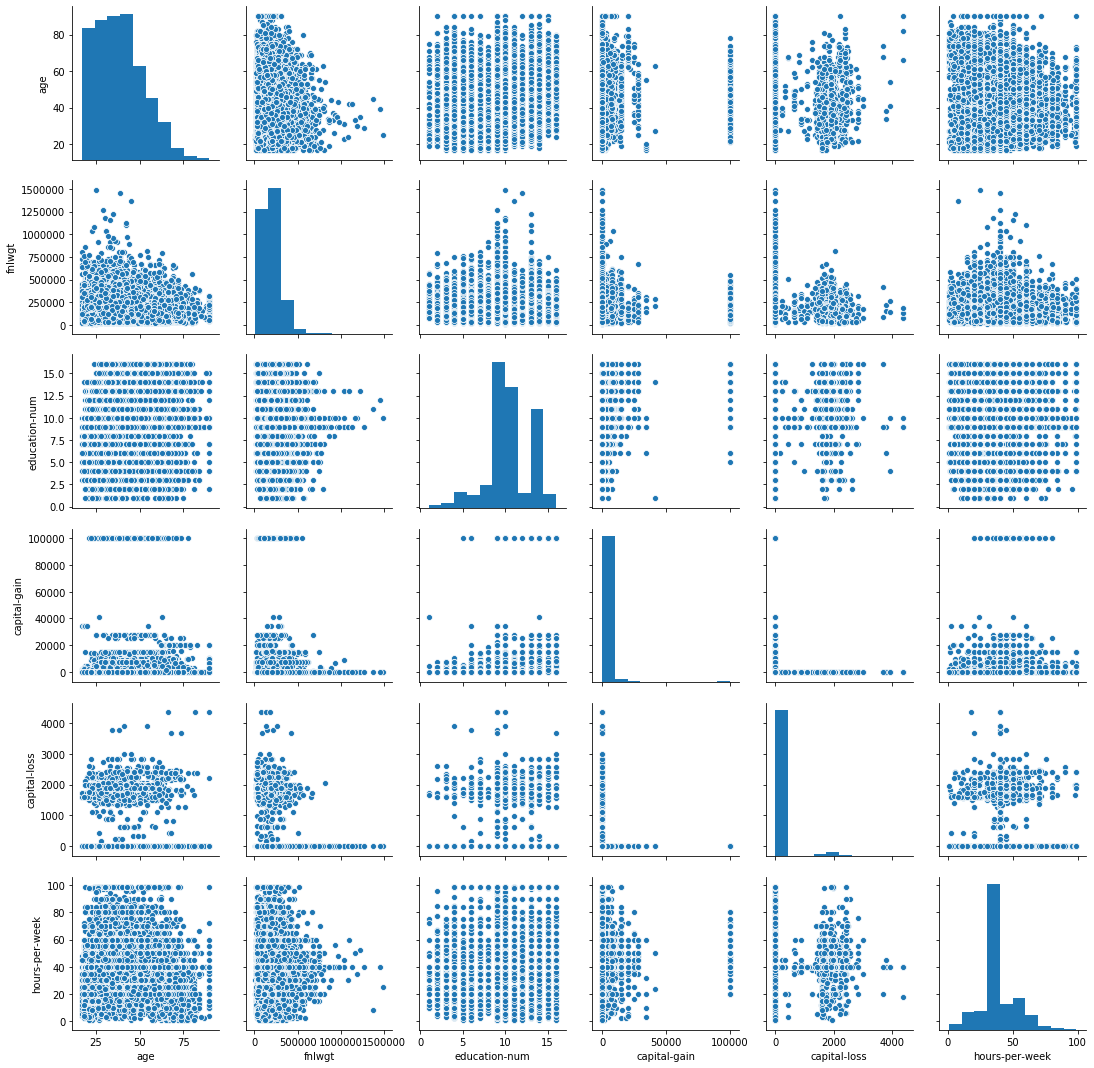

In [16]:
cols = ['age', 'fnlwgt',  'education-num',
       'capital-gain', 'capital-loss','hours-per-week']
sns_plot = sns.pairplot(train[cols].dropna())

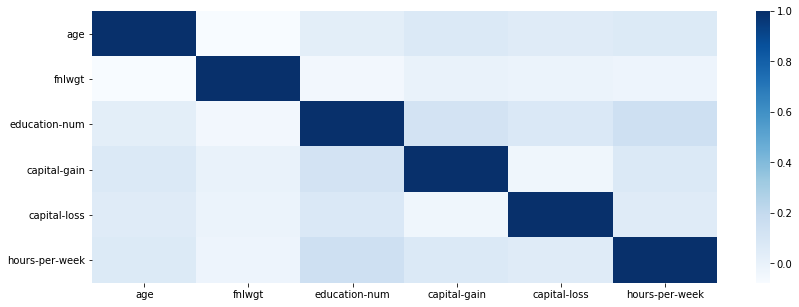

In [17]:
fig = plt.figure(figsize= (14,5))
sns.heatmap(train[cols].dropna().corr(), cmap = 'Blues')

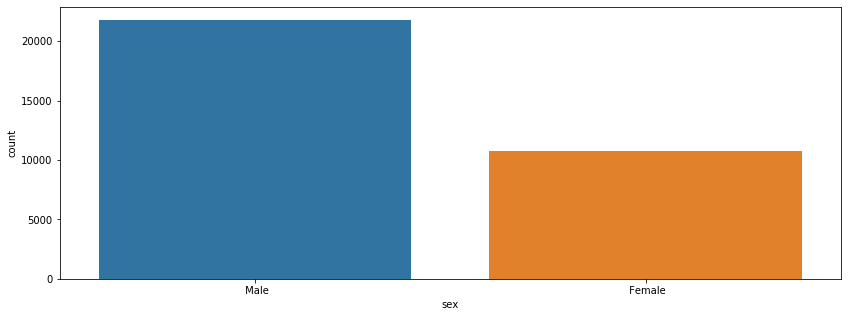

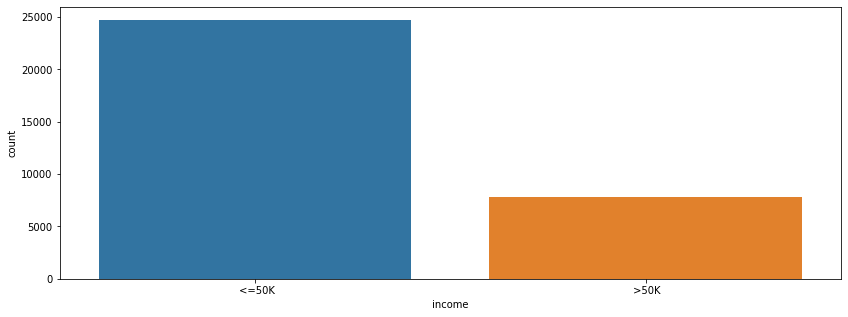

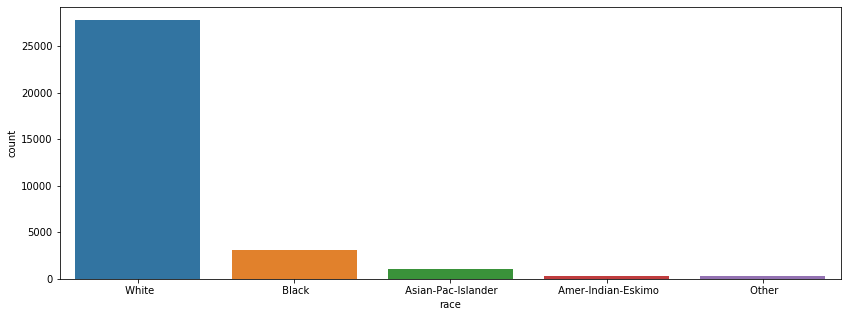

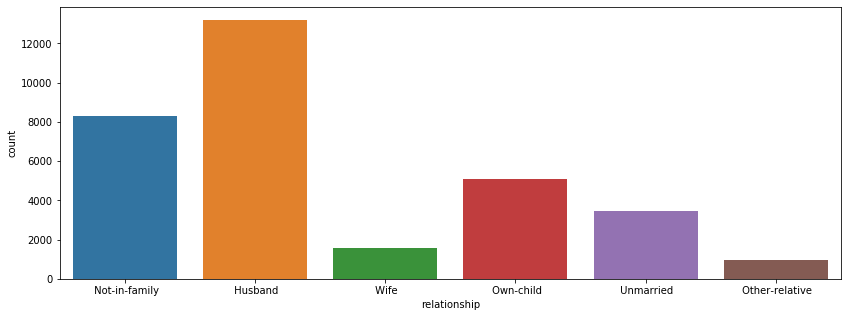

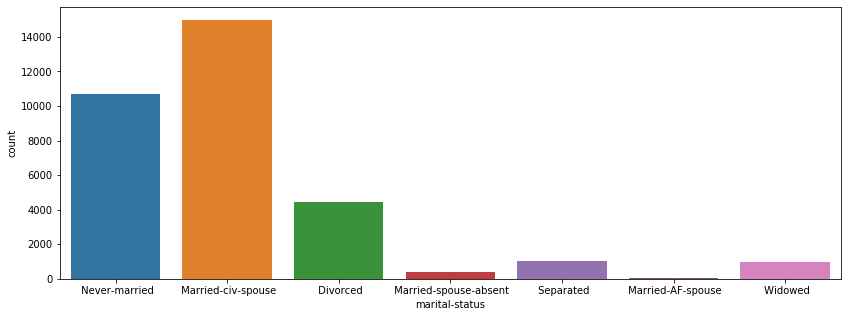

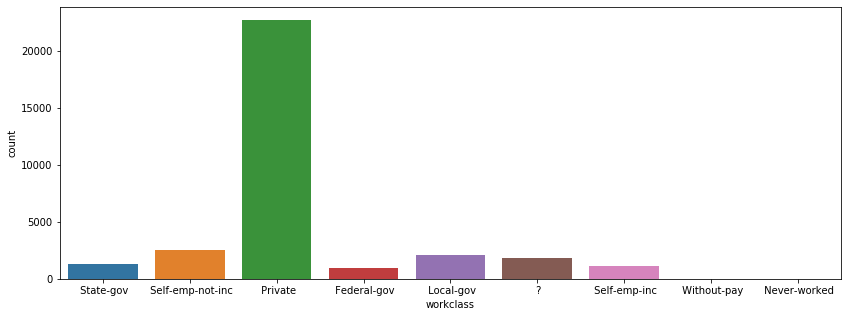

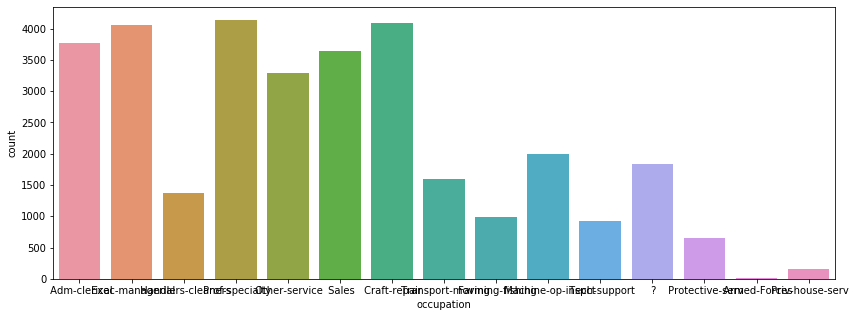

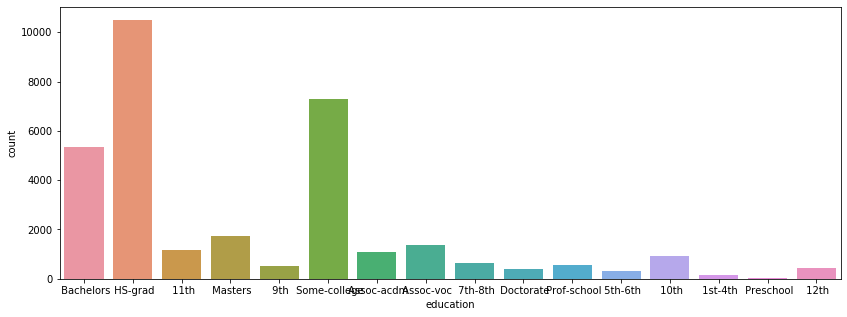

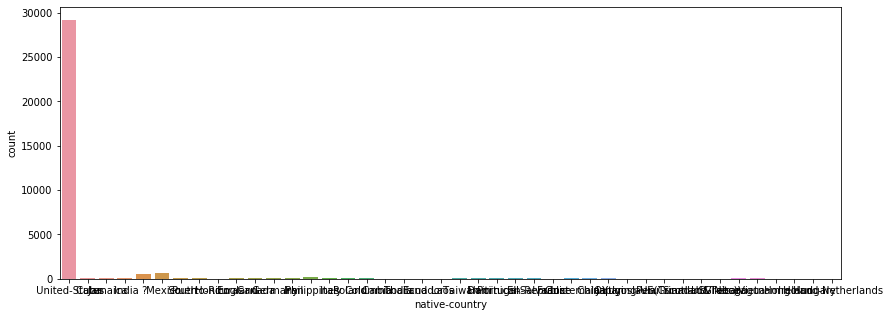

In [18]:
cols = ['sex', 'income',  'race',
       'relationship', 'marital-status','workclass', 'occupation', 'education', 'native-country']
for c in cols:    
    fig = plt.figure(figsize= (14,5))
    sns.countplot(train[c])
    
# wokclass можно попробовать скоррелировать с возрастом и посмотреть, что будет
# marital-status workclass country

In [19]:
unique_counts = pd.DataFrame.from_records([(col, train[col].dtype, train[col].nunique()) for col in train.columns],
                          columns=['Column_Name', 'Type', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Type,Num_Unique
9,sex,object,2
14,income,object,2
8,race,object,5
7,relationship,object,6
5,marital-status,object,7
1,workclass,object,9
6,occupation,object,15
3,education,object,16
4,education-num,int32,16
13,native-country,object,42


In [20]:
show_data(train) 

age: [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
workclass: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
fnlwgt: [ 77516  83311 215646 ...  34066  84661 257302]
education: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
education-num: [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
marital-status: [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
occupation: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Ma

In [21]:
train.income.replace([' >50K', ' <=50K'], [1, 0], inplace=True) 
test.income.replace([' >50K.', ' <=50K.'], [1, 0], inplace=True)

train['income'] = train['income'].astype('int32')
test['income'] = test['income'].astype('int32')

In [22]:
make_NaN(train)
make_NaN(test)

<Figure size 2880x2880 with 0 Axes>

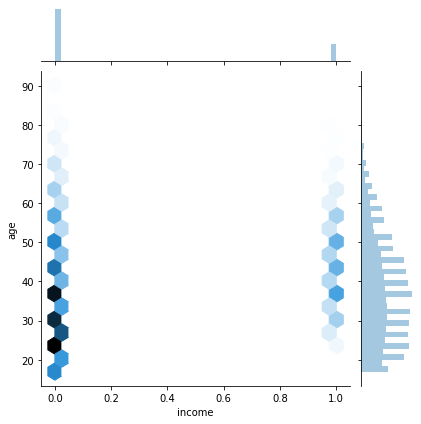

In [23]:
# ДОСТАТОК-ВОЗРАСТ
fig = plt.figure(figsize=(40, 40))
sns.jointplot(x='income', y='age', data=train, kind ='hex',gridsize=20)

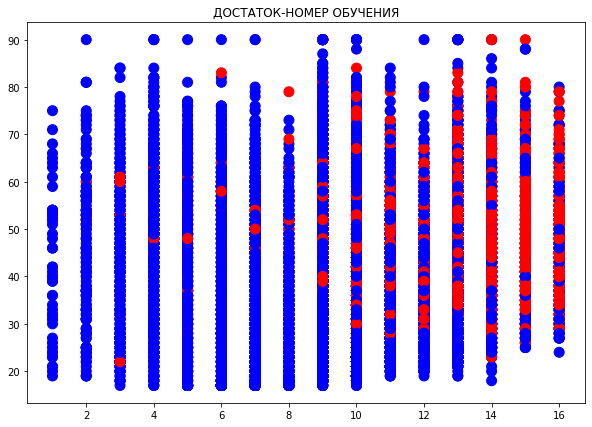

In [24]:
# ДОСТАТОК-НОМЕР ОБУЧЕНИЯ-ВОЗРАСТ
colors = ListedColormap(["blue", "red"])
# 0 - blue
# 1 - red
plt.figure(figsize=(10,7))
plt.title("ДОСТАТОК-НОМЕР ОБУЧЕНИЯ")
plt.scatter(train['education-num'], train['age'], c=train['income'], cmap=colors, s=100)
plt.show()

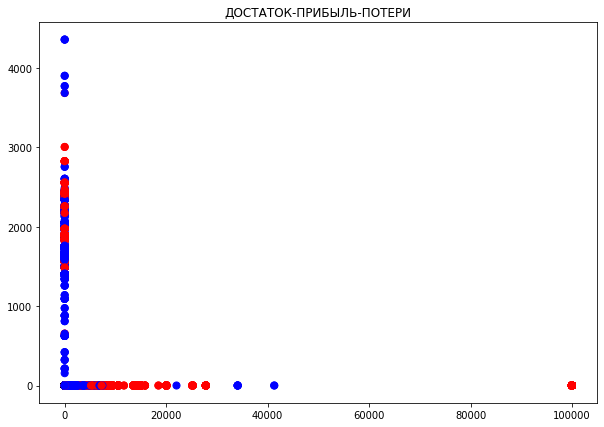

In [25]:
# ДОСТАТОК-ПРИБЫЛЬ-ПОТЕРИ
colors = ListedColormap(["blue", "red"])
# 0 - blue
# 1 - red
plt.figure(figsize=(10,7))
plt.title("ДОСТАТОК-ПРИБЫЛЬ-ПОТЕРИ")
plt.scatter(train['capital-gain'], train['capital-loss'], c=train['income'], cmap=colors, s=50)
plt.show()

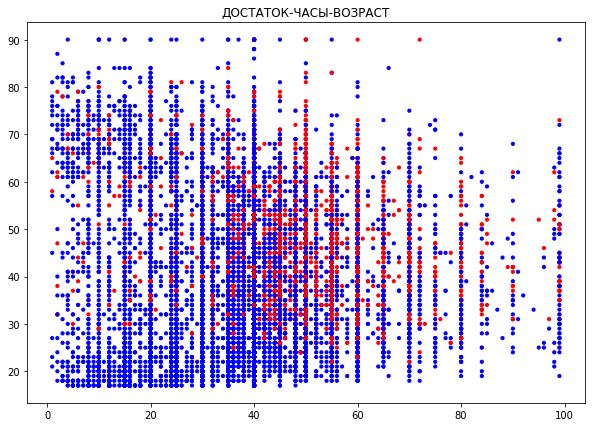

In [26]:
# ДОСТАТОК-ЧАСЫ-ВОЗРАСТ
colors = ListedColormap(["blue", "red"])
# 0 - blue
# 1 - red
plt.figure(figsize=(10,7))
plt.title("ДОСТАТОК-ЧАСЫ-ВОЗРАСТ")
plt.scatter(train['hours-per-week'], train['age'], c=train['income'], cmap=colors, s=10)
plt.show()
#те кто мало или много работают, скорее всего, мало не получают

<BarContainer object of 10 artists>

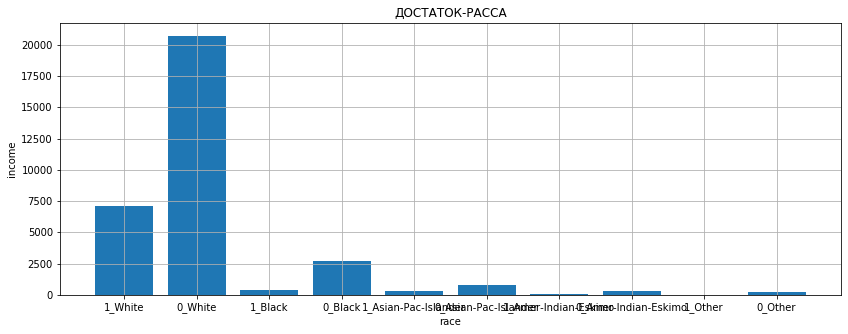

In [27]:
# ДОСТАТОК-РАССА

cols = [' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' Other']
cls = ['1_White', '0_White', '1_Black', '0_Black', '1_Asian-Pac-Islander', '0_Asian-Pac-Islander', '1_Amer-Indian-Eskimo', '0_Amer-Indian-Eskimo', '1_Other', '0_Other']

values = []

for c in cols:
    values.append(train[train.race == c][['income']].income.sum())
    values.append(train[(train.race == c) & (train.income == 0)][['income']].income.count())

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot()
ax1.set_xlabel('race')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-РАССА')
ax1.grid()
ax1.bar(cls, values) 

<BarContainer object of 4 artists>

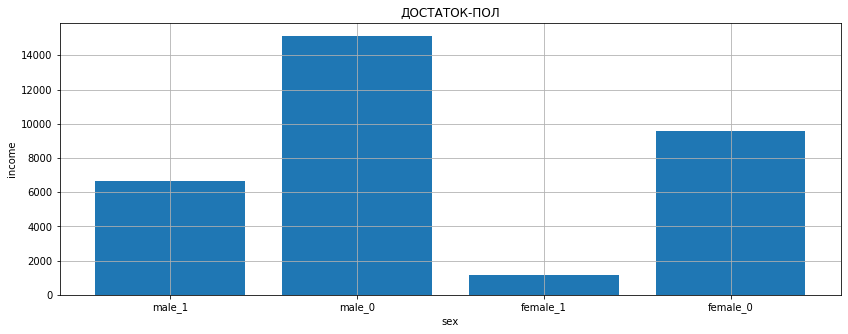

In [28]:
# ДОСТАТОК-ПОЛ

sex = ['male_1','male_0', 'female_1', 'female_0']

male_1 = train[train.sex == ' Male'][['income']].income.sum()
male_0 = train[(train.sex == ' Male') & (train.income == 0)][['sex']].count()
female_1 = train[train.sex == ' Female'][['income']].income.sum()
female_0 = train[(train.sex == ' Female') & (train.income == 0)][['sex']].count()

cls = [male_1, male_0, female_1, female_0]

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot()
ax1.set_xlabel('sex')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ПОЛ')
ax1.grid()
ax1.bar(sex, cls) 

<BarContainer object of 16 artists>

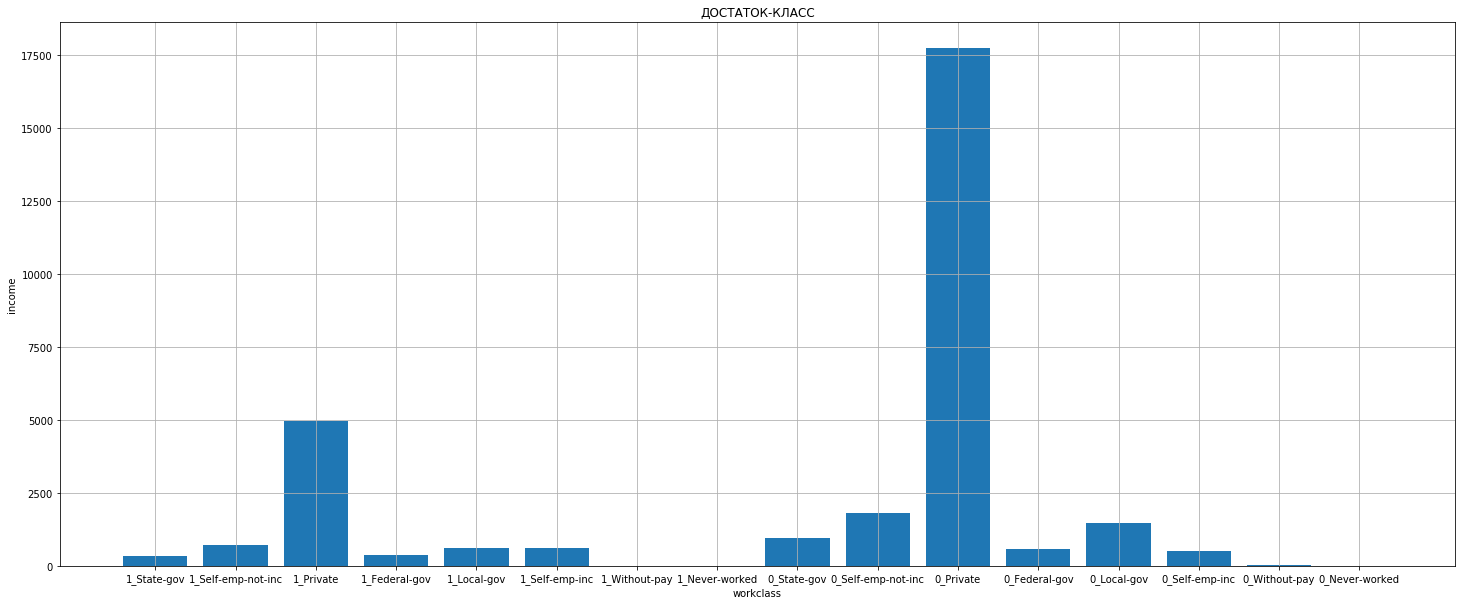

In [29]:
# ДОСТАТОК-КЛАСС
cls = ['1_State-gov', '1_Self-emp-not-inc', '1_Private', '1_Federal-gov', '1_Local-gov',
 '1_Self-emp-inc', '1_Without-pay', '1_Never-worked', '0_State-gov', '0_Self-emp-not-inc', '0_Private', '0_Federal-gov', '0_Local-gov',
 '0_Self-emp-inc', '0_Without-pay', '0_Never-worked']
 
cols = [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' Without-pay', ' Never-worked']

cls_1 = []
cls_0 = []

for col in cols:
    cls_1.append(train[train.workclass == col][['income']].income.sum())
    cls_0.append(train[(train.workclass == col) & (train.income == 0)][['workclass']].workclass.count())

clss = cls_1 + cls_0

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('workclass')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-КЛАСС')
ax1.grid()
ax1.bar(cls, clss) 

<BarContainer object of 16 artists>

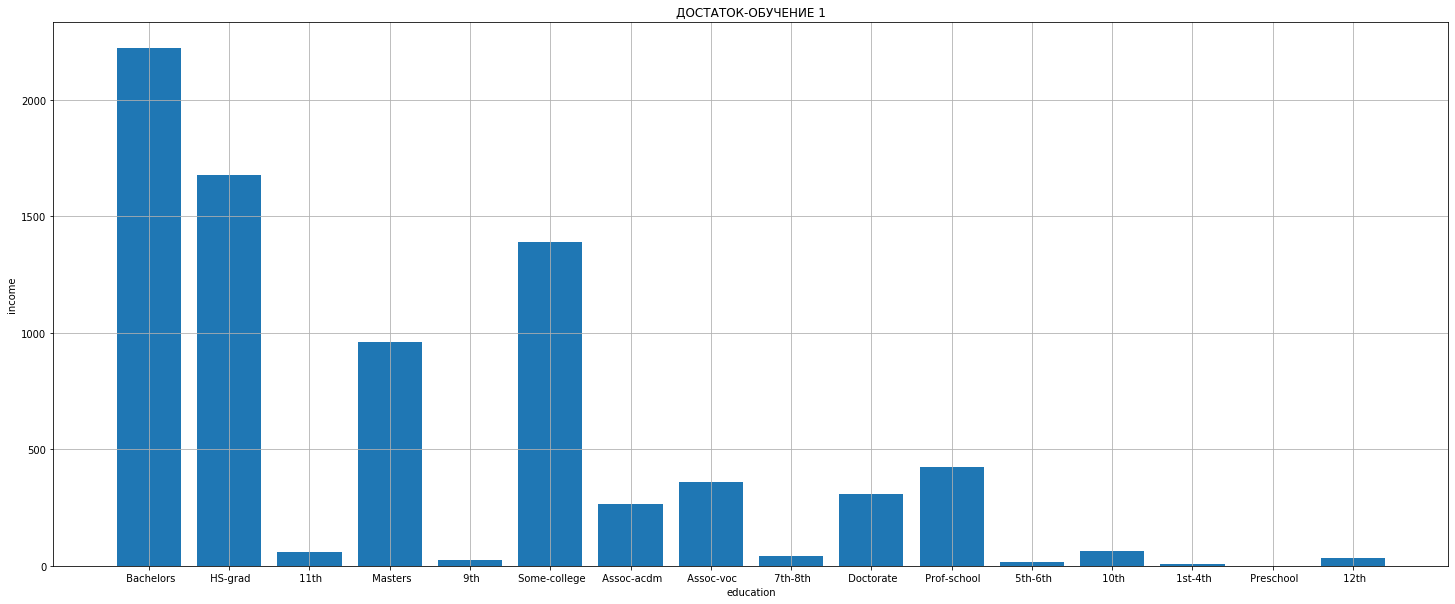

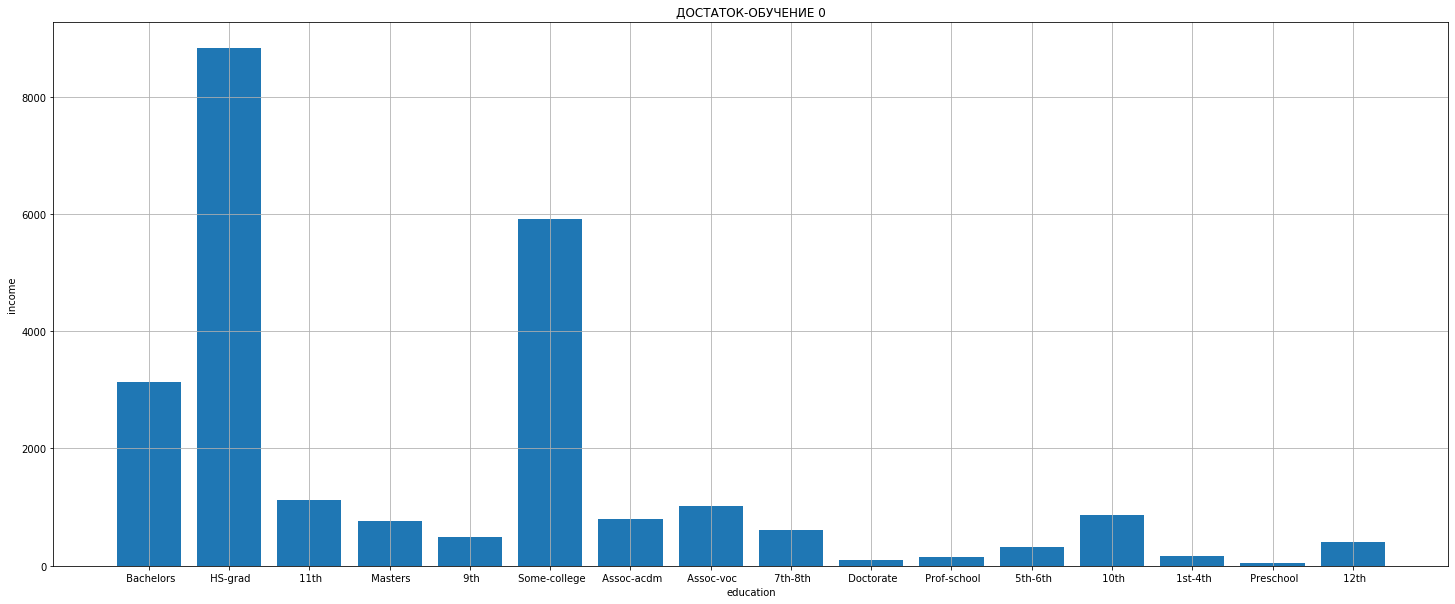

In [30]:
# ДОСТАТОК-ОБУЧЕНИЕ

cls = [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college',
 ' Assoc-acdm', ' Assoc-voc', ' 7th-8th', ' Doctorate', ' Prof-school',
 ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th']

cls_1 = []
cls_0 = []

for col in cls:
    cls_1.append(train[train.education == col][['income']].income.sum())
    cls_0.append(train[(train.education == col) & (train.income == 0)][['education']].education.count())

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('education')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ОБУЧЕНИЕ 1')
ax1.grid()
ax1.bar(cls, cls_1) 

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('education')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ОБУЧЕНИЕ 0')
ax1.grid()
ax1.bar(cls, cls_0) 

In [31]:
train.corr()
# age, education-num, capital-gain, capital-loss, hours-per-week

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
income,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


In [32]:
find_NaN(train)

Index(['workclass', 'occupation', 'native-country'], dtype='object')
workclass         1836
occupation        1843
native-country     583
dtype: int64


In [33]:
# occupation
for col in train.columns:
    if train[col].dtype == object:
        print(pd.crosstab(train[col], train['occupation']))
        print('\n\n\n')

occupation          Adm-clerical   Armed-Forces   Craft-repair  \
workclass                                                        
 Federal-gov                 317              9             64   
 Local-gov                   283              0            146   
 Private                    2833              0           3195   
 Self-emp-inc                 31              0            106   
 Self-emp-not-inc             50              0            531   
 State-gov                   253              0             56   
 Without-pay                   3              0              1   

occupation          Exec-managerial   Farming-fishing   Handlers-cleaners  \
workclass                                                                   
 Federal-gov                    180                 8                  23   
 Local-gov                      214                29                  47   
 Private                       2691               455                1273   
 Self-emp-inc       

occupation            Adm-clerical   Armed-Forces   Craft-repair  \
race                                                               
 Amer-Indian-Eskimo             31              1             44   
 Asian-Pac-Islander            139              0             89   
 Black                         490              1            244   
 Other                          26              0             28   
 White                        3084              7           3694   

occupation            Exec-managerial   Farming-fishing   Handlers-cleaners  \
race                                                                          
 Amer-Indian-Eskimo                30                10                  22   
 Asian-Pac-Islander               135                16                  23   
 Black                            244                42                 179   
 Other                             11                11                  12   
 White                           3646            

# ПОДГОТОВКА ДАННЫХ

In [34]:
def delete_NaN(df):
    #cols = ['workclass', 'occupation', 'native-country']
    df['workclass'][df['workclass'].isnull()] = df.describe(include=['object']).loc['top', 'workclass']
    df['occupation'][df['occupation'].isnull()] = df.describe(include=['object']).loc['top', 'occupation']
    df['native-country'][df['native-country'].isnull()] = df.describe(include=['object']).loc['top', 'native-country']

def one_hot(df, col):    
    dfs = pd.get_dummies(df[col], prefix=col)
    df_ = pd.concat([df, dfs], axis=1)
    df_ = df_.drop(col, axis=1)
    return df_

def transform_df(df):
    unique_counts = pd.DataFrame.from_records([(col, df[col].dtype, df[col].nunique()) for col in df.columns],
                          columns=['Column_Name', 'Type', 'Num_Unique']).sort_values(by=['Num_Unique'])
    df_ = df.copy()
    for col in df.columns:
        if (col == 'capital-gain') | (col == 'capital-loss'):
            df_[col] = (df_[col] - df_[col].mean()) / df_[col].std()
        elif (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] == 2) & (df_[col].dtype == object):
            values = df_[col].unique()
            df_[col].replace(values, [1, 0], inplace=True) 
        elif (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] < 10) & (df_[col].dtype == object):
            df_ = one_hot(df_, col).copy()
        elif  (unique_counts[unique_counts['Column_Name'] == col][['Num_Unique']].values[0][0] >= 10) & (df_[col].dtype == object):
            #df_[col] = df_[col].astype('category')   
            values = df_[col].unique()
            l = [i for i in range(len(values))] 
            df_[col].replace(values, l, inplace=True)
    return df_

In [35]:
unnessesary = ['fnlwgt']

In [36]:
X = train.copy()
delete_NaN(X)
X = train.drop(unnessesary, axis=1)
X = X.drop('income', axis=1)
X = transform_df(X).copy()
X.head()

,age,education,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,39,0,13,0,1,0.148451,-0.216656,40,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,50,0,13,1,1,-0.145918,-0.216656,13,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,38,1,9,2,1,-0.145918,-0.216656,40,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,53,2,7,2,1,-0.145918,-0.216656,40,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,28,0,13,3,0,-0.145918,-0.216656,40,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [37]:
y = pd.DataFrame(train['income'])
test_ = test.drop('income', axis=1)
delete_NaN(test_)
test_ = test_.drop(unnessesary, axis=1)
test_ = transform_df(test_).copy()
target = pd.DataFrame(test['income'])
test_.head()

,age,education,education-num,occupation,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White
0,25,0,7,0,1,-0.142657,-0.218055,40,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
1,38,1,9,1,1,-0.142657,-0.218055,50,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,28,2,12,2,1,-0.142657,-0.218055,40,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,44,3,10,0,1,0.871064,-0.218055,40,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,18,3,10,3,0,-0.142657,-0.218055,30,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1


In [38]:
X.to_csv('data/X_adult.csv')
y.to_csv('data/Y_adult.csv')
test_.to_csv('data/test_adult.csv')
target.to_csv('data/target_adult.csv')